**Bibliotecas**

In [2]:
import os
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from os import getcwd
import zipfile
import shutil
import numpy as np
import glob
import random
import pandas as pd
import matplotlib.pyplot as plt


from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split

**Montar o google drive no Colab**

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

**Importar arquivos de configuração do Kaglle**

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"fabiobasson","key":"d71cbfdfd23379909173204eac74cf96"}'}

In [4]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

### ** Download dos dados / descompactando os dados**

In [5]:
!kaggle datasets download phylake1337/fire-dataset

 98% 379M/387M [00:03<00:00, 123MB/s]
100% 387M/387M [00:03<00:00, 126MB/s]


In [27]:
!kaggle datasets download tanyadayanand/geological-image-similarity
! unzip -qq geological-image-similarity

geological-image-similarity.zip: Skipping, found more recently modified local copy (use --force to force download)


In [6]:
!unzip -qq fire-dataset.zip

**Criando o Diretorio Df e unificando os dados dentro dele (não utilizado)**

In [7]:
! mkdir df
!cp -r fire_dataset/fire_images/* df
! cp -r fire_dataset/non_fire_images/* df

### Data Preprocessing

In [8]:
fire_dir = glob.glob('fire_dataset/fire_images/*.png')
non_fire_dir = glob.glob('fire_dataset/non_fire_images/*.png')

In [9]:
fire_df = []
non_fire_df = []
for i in fire_dir:
    fire_df.append([i,'fire'])
for j in non_fire_dir:
    non_fire_df.append([j,'non_fire'])
df = fire_df + non_fire_df
random.shuffle(df)

In [24]:
!rm -r df

In [ ]:
data_df = pd.DataFrame(df, columns = ['path','label'])

## ** Esta função irá plotar as imagens num grid de 1 a te5 colunas **

In [7]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

In [8]:
IMG_SHAPE = 256
BATCH_SIZE = 20

In [9]:
datagen = ImageDataGenerator(rescale=1./255,
                            #rotation_range = 40,
                            #width_shift_range = 0.2,
                            #height_shift_range = 0.2,
                            #shear_range = 0.2,
                            #zoom_range = 0.2,
                            horizontal_flip = True,
                            validation_split=0.2)

In [10]:
train_generator = datagen.flow_from_directory(batch_size=BATCH_SIZE,
                                               directory="fire_dataset",
                                               shuffle=True,
                                               target_size=(IMG_SHAPE,IMG_SHAPE),
                                               class_mode='binary',
                                               subset='training')

validation_generator = datagen.flow_from_directory(batch_size=BATCH_SIZE,
                                                 directory="fire_dataset",
                                                 target_size=(IMG_SHAPE, IMG_SHAPE),
                                                 class_mode='binary',
                                                 subset='validation')

Found 800 images belonging to 2 classes.
Found 199 images belonging to 2 classes.


**Outra forma de fazer o train e validation generator**

In [ ]:
train_generator = datagen.flow_from_dataframe(data_df,
                                              x_col='path',
                                              y_col='label',
                                              images_size=(256,256),
                                              class_mode='binary',
                                              subset='training')

validation_generator = datagen.flow_from_dataframe(data_df,
                                                   x_col='path',
                                                   y_col='label',
                                                   images_size=(256,256),
                                                   class_mode='binary',
                                                   subset='validation')


Found 800 validated image filenames belonging to 2 classes.
Found 199 validated image filenames belonging to 2 classes.


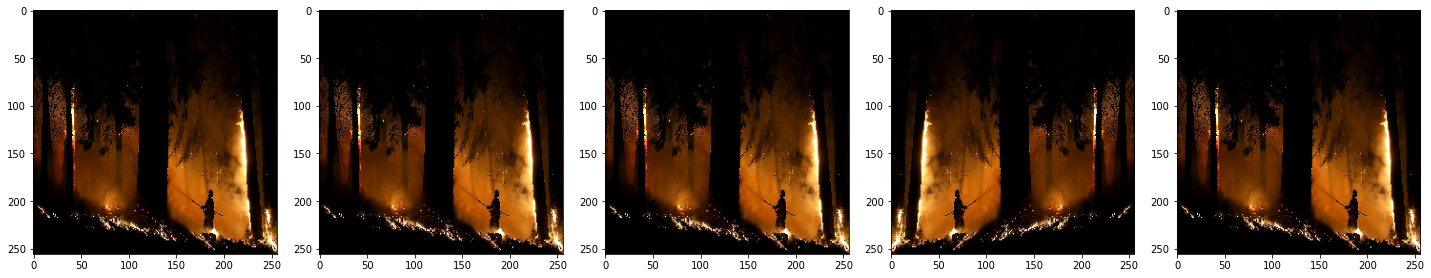

In [11]:
augmented_images = [train_generator[0][0][0] for i in range(5)]
plotImages(augmented_images)

In [26]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(256, 256, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(2)
])

**Compilando o Modelo**

In [27]:
model.compile(optimizer = Adam(learning_rate=0.0001), 
               loss = 'binary_crossentropy', 
               metrics =['accuracy'])

In [28]:
model.summary()   

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 128)       1

In [29]:
callbacks_list = [
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.5,
                                         patience=4,
                                         verbose=0),
    tf.keras.callbacks.EarlyStopping(
        monitor="accuracy",
        patience=12,
        #restore_best_weights=True,
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath='best_model.h5',
        monitor="val_accuracy",
        save_best_only=True,
    ),

]

In [30]:
history = model.fit(train_generator,
                               epochs=20,
                               #verbose=0,
                               callbacks=callbacks_list, 
                               #validation_split=0.2,
                               #class_weight=class_weight_,
                               workers=4,
                               use_multiprocessing=True,
                               validation_data=validation_generator)

Epoch 1/20
40/40 [==============================] - 155s 4s/step - loss: 2.1052 - accuracy: 0.4588 - val_loss: 2.1031 - val_accuracy: 0.8040
Epoch 2/20
40/40 [==============================] - 154s 4s/step - loss: 2.1055 - accuracy: 0.8325 - val_loss: 2.1096 - val_accuracy: 0.8342
Epoch 3/20
40/40 [==============================] - 152s 4s/step - loss: 2.1776 - accuracy: 0.7862 - val_loss: 2.1094 - val_accuracy: 0.5477
Epoch 4/20
40/40 [==============================] - 156s 4s/step - loss: 1.9833 - accuracy: 0.8300 - val_loss: 2.0521 - val_accuracy: 0.7035
Epoch 5/20
40/40 [==============================] - 161s 4s/step - loss: 2.0202 - accuracy: 0.9050 - val_loss: 2.6922 - val_accuracy: 0.8894
Epoch 6/20
40/40 [==============================] - 157s 4s/step - loss: 2.0003 - accuracy: 0.9013 - val_loss: 2.0364 - val_accuracy: 0.8995
Epoch 7/20
40/40 [==============================] - 159s 4s/step - loss: 1.9770 - accuracy: 0.8662 - val_loss: 1.9951 - val_accuracy: 0.7688
Epoch 8/20
40

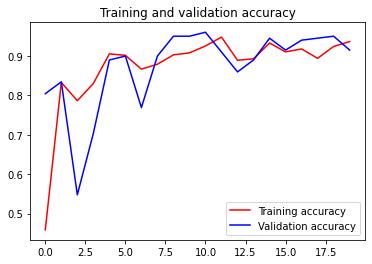

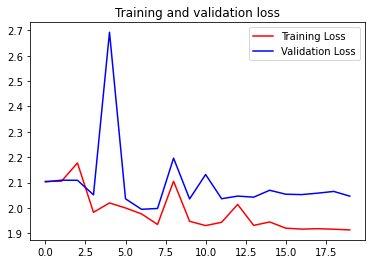

In [31]:
%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [32]:
model = tf.keras.models.load_model("best_model.h5")

val_acc1 = model.evaluate(validation_generator)[1]
print("validation_accuracy: " + str(val_acc1))

10/10 [==============================] - 10s 946ms/step - loss: 2.0956 - accuracy: 0.9598
validation_accuracy: 0.9597989916801453


## **listando as redes realmente disponíveis em seu Keras**

In [12]:
import tensorflow.keras.applications as app
print(dir(app))

['DenseNet121', 'DenseNet169', 'DenseNet201', 'EfficientNetB0', 'EfficientNetB1', 'EfficientNetB2', 'EfficientNetB3', 'EfficientNetB4', 'EfficientNetB5', 'EfficientNetB6', 'EfficientNetB7', 'InceptionResNetV2', 'InceptionV3', 'MobileNet', 'MobileNetV2', 'MobileNetV3Large', 'MobileNetV3Small', 'NASNetLarge', 'NASNetMobile', 'ResNet101', 'ResNet101V2', 'ResNet152', 'ResNet152V2', 'ResNet50', 'ResNet50V2', 'VGG16', 'VGG19', 'Xception', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', '_sys', 'densenet', 'efficientnet', 'imagenet_utils', 'inception_resnet_v2', 'inception_v3', 'mobilenet', 'mobilenet_v2', 'mobilenet_v3', 'nasnet', 'resnet', 'resnet50', 'resnet_v2', 'vgg16', 'vgg19', 'xception']


# **O Modelo pre treinado VGG16.**

In [13]:
conv_base = tf.keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(256, 256, 3))

58900480/58889256 [==============================] - 1s 0us/step


In [14]:
inputs = tf.keras.Input(shape=(256, 256, 3))
#x = datagen(inputs)
x = conv_base(inputs)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
modelvgg16 = tf.keras.Model(inputs, outputs)

modelvgg16.compile(optimizer = Adam(learning_rate=0.0001,decay=1e-5), 
               loss = 'binary_crossentropy', 
               metrics =['acc'])

callbacksvgg16 = [
    tf.keras.callbacks.ModelCheckpoint(
      filepath='feature_extraction.vgg16',
      save_best_only=True,
      monitor="val_loss")
]

In [15]:
history = modelvgg16.fit(train_generator,
                         epochs=5,
                         verbose=1,
                         validation_data=validation_generator,
                         callbacks=callbacksvgg16)

Epoch 1/5
40/40 [==============================] - 2140s 53s/step - loss: 0.4352 - acc: 0.8175 - val_loss: 0.2771 - val_acc: 0.8844
INFO:tensorflow:Assets written to: feature_extraction.vgg16/assets
Epoch 2/5
40/40 [==============================] - 2100s 53s/step - loss: 0.2254 - acc: 0.9150 - val_loss: 0.2041 - val_acc: 0.9146
INFO:tensorflow:Assets written to: feature_extraction.vgg16/assets
Epoch 3/5
40/40 [==============================] - 2096s 52s/step - loss: 0.1887 - acc: 0.9287 - val_loss: 0.1971 - val_acc: 0.8995
INFO:tensorflow:Assets written to: feature_extraction.vgg16/assets
Epoch 4/5
40/40 [==============================] - 2108s 53s/step - loss: 0.1135 - acc: 0.9625 - val_loss: 0.1740 - val_acc: 0.9246
INFO:tensorflow:Assets written to: feature_extraction.vgg16/assets
Epoch 5/5
40/40 [==============================] - 2093s 52s/step - loss: 0.1323 - acc: 0.9638 - val_loss: 0.7362 - val_acc: 0.6533


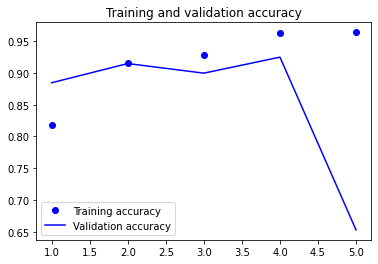

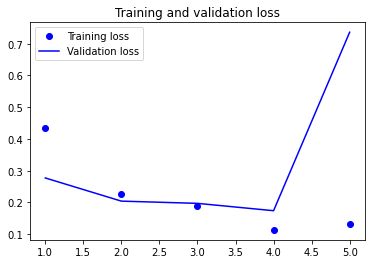

In [18]:
import matplotlib.pyplot as plt
acc = history.history["acc"]
val_acc = history.history["val_acc"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [19]:
model = tf.keras.models.load_model("feature_extraction.vgg16")

val_acc1 = model.evaluate(validation_generator)[1]
print("validation_accuracy: " + str(val_acc1))

10/10 [==============================] - 136s 14s/step - loss: 0.1774 - acc: 0.9246
validation_accuracy: 0.9246231317520142


**### O Modelo pre treinado InceptionV3**

In [20]:
Inception_V3 = InceptionV3(input_shape=(256,256,3),
                           include_top=False)
Inception_V3.trainable = False

87924736/87910968 [==============================] - 1s 0us/step


In [21]:
Inception_V3.input

<KerasTensor: shape=(None, 256, 256, 3) dtype=float32 (created by layer 'input_3')>

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(256, 256, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(2)
])

In [22]:
from keras import models
from keras import layers

x = layers.Flatten()(Inception_V3.output)
x = layers.BatchNormalization()(x)
x = layers.Dense(1024,activation='relu')(x)
x = layers.Dropout(0.2)(x)                  
x = layers.Dense(1,activation='sigmoid')(x)           

model_Inception_V3 = Model(Inception_V3.input, x) 

In [23]:
model_Inception_V3.compile(optimizer = Adam(learning_rate=0.0001,decay=1e-5), 
               loss = 'binary_crossentropy', 
               metrics =['acc'])

In [ ]:
history = model_Inception_V3.fit(train_generator,
                               epochs=20,
                               verbose=1,
                               validation_data=validation_generator)

Epoch 1/20
50/50 [==============================] - ETA: 0s - loss: 0.6763 - acc: 0.9019

KeyboardInterrupt: ignored

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
val_acc1= model_Inception_V3.evaluate(validation_generator)[1]
print("validation_accuracy: " + str(val_acc1))

**O Modelo pre treinado VGG16 EfficientNet B0**

In [ ]:
from tensorflow.keras.applications import EfficientNetB0

In [ ]:
efficientnet_b0 = EfficientNetB0(include_top=False,
                             weights="imagenet",
                             input_shape=(256,256,3))
efficientnet_b0.trainable = False

In [ ]:
x = layers.Flatten()(efficientnet_b0.output)
x = layers.BatchNormalization()(x)
x = layers.Dense(1024,activation='relu')(x)
x = layers.Dropout(0.2)(x)                  
x = layers.Dense(1,activation='sigmoid')(x)           

model2 = Model(efficientnet_b0.input, x) 

model2.compile(optimizer = Adam(lr=0.0001), 
               loss = 'binary_crossentropy', 
               metrics =['acc'])

In [ ]:
history = model2.fit_generator(train_generator,
                               epochs=50,
                               verbose=0,
                               validation_data=validation_generator)

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
val_acc2 = model2.evaluate(validation_generator)[1]
print("validation_accuracy: " + str(val_acc2))

### O Modelo pre treinado EfficientNet B7

In [ ]:
from tensorflow.keras.applications import EfficientNetB7

In [ ]:
efficientnet_b7 = EfficientNetB7(include_top=False,
                                 weights="imagenet",
                                 input_shape=(256,256,3))
efficientnet_b7.trainable = False

In [ ]:
x = layers.Flatten()(efficientnet_b7.output)
x = layers.BatchNormalization()(x)
x = layers.Dense(1024,activation='relu')(x)
x = layers.Dropout(0.2)(x)                  
x = layers.Dense(1,activation='sigmoid')(x)           

model3 = Model(efficientnet_b7.input, x) 

model3.compile(optimizer = Adam(lr=0.0001), 
               loss = 'binary_crossentropy', 
               metrics =['acc'])

In [ ]:
history = model3.fit_generator(train_generator,epochs=50,
                               verbose=0,
                               validation_data=validation_generator)

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
val_acc3 = model3.evaluate(validation_generator)[1]
print("validation_accuracy: " + str(val_acc3))

**negrito**### Comparando os modelos

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
acc = [val_acc1,val_acc2,val_acc3]
model = ['InceptionV3','EfficientNetB0','EfficientNetB7']
ax.bar(model,acc)
plt.show()